In [1]:
import numpy as np
import sympy as sym
import symbolic_solver as ss
from sympy.physics.control.control_plots import bode_plot, bode_magnitude_numerical_data, bode_phase_numerical_data
from sympy.physics.control.lti import TransferFunctionMatrix, TransferFunction

In [13]:
import matplotlib.pyplot as plt
from gmid.mosplot import load_lookup_table, LoadMosfet

lookup_table = load_lookup_table("sky130A_LUT_lvt.npy")

## LDO specifications and OTA transistors definition

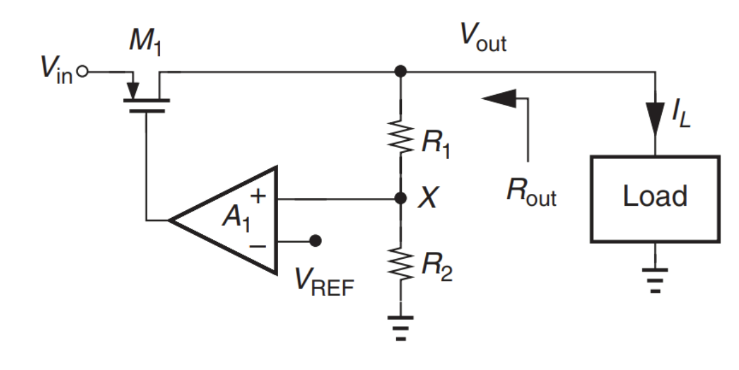

In [15]:
## LDO operation point
Vreg = 1.2                                     # LDO output voltage
Vdd = 1.8                                      # LDO supply voltage
Vref = 0.8                                     # LDO voltage reference
R1 = 100000                                    # Resistance 1, could be changed to meet size specifications
iq = 0.0000015                                 # Current through the OTA. (it depends on the pre-designed OTA)
R2 = int(R1/((Vreg/Vref)-1))                   # R2 as a function of the voltage ratio
il = 0.000667                                  # Load current
cl = 5e-12                                     # Load capacitance

## LDO exploration parameters
l3 = [0.4e-06, 0.6e-06, 0.8e-06, 1.6e-06]      # Length exploration values.
gmid_sweep = np.arange(5,25,0.2)               # gm/id sweep for exploration.

### OTA transistor definition

This parameters should be obtained from the OTA squematic provided by the user. For the moment the parameters of the transistor are given directly with a previous DC simulation.

In [11]:
class Transistor():
    def __init__(self, model, gm, gds, cgs, cgd):
        self.model = model
        self.gm = gm
        self.gds = gds
        self.cgs = cgs
        self.cgd = cgd

M_1a = Transistor("nmos", gm=1.3385e-05, gds=1.1652e-07, cgs=1.7e-15, cgd=2.5e-19)
M_1b = Transistor("nmos", gm=1.517e-05, gds=1.69e-07, cgs=1.7e-15, cgd=2.51e-19)

M_2a = Transistor("pmos", gm=6.7641e-06, gds=1.856e-07, cgs=2.4e-15, cgd=9.87e-19)
M_2b = Transistor("pmos", gm=7.4378e-06, gds=1.538e-07, cgs=2.4e-15, cgd=9.87e-19)

M_4a = Transistor("pmos", gm=1.65e-05, gds=1.97e-07, cgs=2.11e-15, cgd=8.35e-17)
M_4b = Transistor("pmos", gm=1.583e-05, gds=5.32e-07, cgs=2.12e-15, cgd=2.72e-18)

## Pass Transistor generation

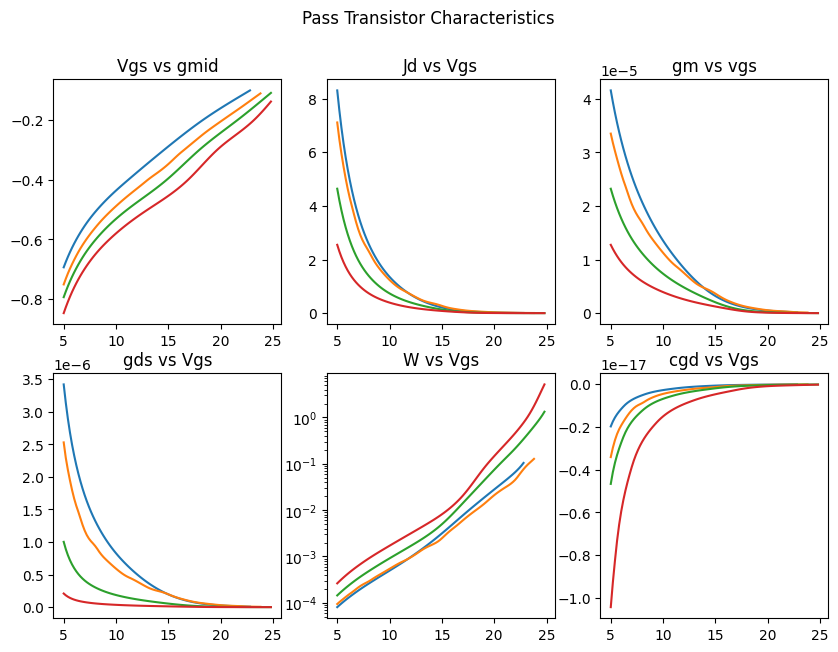

In [19]:
## Transistor object definition to save the pass transistor parameters.
class Exploration_Transistor():
    def __init__(self, model=None):
        self.model = model

## First create generic pmos mosfet, for this we should consider:
## 1. the vds value the drop voltage from vdd to vreg.
M_3_table = LoadMosfet(lookup_table=lookup_table, mos="pmos", vsb=0, vds=-(Vdd-Vreg), vgs=(-1.8, -0.1, 0.1), lengths = l3)

## Creacion de transistor
M_3 = Exploration_Transistor()

## pass transistor drain current.
M_3.id = il+Vreg/(R1+R2)

### Vgs con barrido en Gm/id para distintos L
M_3.vgs = M_3_table.interpolate(
            x_expression=M_3_table.lengths_expression,
            x_value=l3,
            y_expression=M_3_table.gmid_expression,
            y_value=gmid_sweep,
            z_expression=M_3_table.vgs_expression,
        )
### Jd con barrido en Vgs para distintos L
M_3.Jd = []
for idx, x in enumerate(l3):
    temp = M_3_table.interpolate(
                x_expression=M_3_table.lengths_expression,
                x_value=x,
                y_expression=M_3_table.vgs_expression,
                y_value=M_3.vgs[idx,:],
                z_expression=M_3_table.current_density_expression,
            )
    M_3.Jd.append(temp)
M_3.Jd = np.vstack(M_3.Jd)

### Gm con barrido en Vgs para distintos L
M_3.gm = []
for idx, x in enumerate(l3):
    temp = M_3_table.interpolate(
                x_expression=M_3_table.lengths_expression,
                x_value=x,
                y_expression=M_3_table.vgs_expression,
                y_value=M_3.vgs[idx,:],
                z_expression=M_3_table.gm_expression,
            )
    M_3.gm.append(temp)
M_3.gm = np.vstack(M_3.gm)

### Gds con barrido en Vgs para distintos L
M_3.gds = []
for idx, x in enumerate(l3):
    temp = M_3_table.interpolate(
                x_expression=M_3_table.lengths_expression,
                x_value=x,
                y_expression=M_3_table.vgs_expression,
                y_value=M_3.vgs[idx,:],
                z_expression=M_3_table.gds_expression,
            )
    M_3.gds.append(temp)
M_3.gds = np.vstack(M_3.gds)

M_3.W = np.divide(M_3.id, M_3.Jd)

### Cgd con barrido en Vgs para distintos L
M_3.cgd = []
for idx, x in enumerate(l3):
    temp = M_3_table.interpolate(
                x_expression=M_3_table.lengths_expression,
                x_value=x,
                y_expression=M_3_table.vgs_expression,
                y_value=M_3.vgs[idx,:],
                z_expression=M_3_table.cgd_expression,
            )
    M_3.cgd.append(temp)
M_3.cgd = np.vstack(M_3.cgd)

### Cgs con barrido en Vgs para distintos L
M_3.cgs = []
for idx, x in enumerate(l3):
    temp = M_3_table.interpolate(
                x_expression=M_3_table.lengths_expression,
                x_value=x,
                y_expression=M_3_table.vgs_expression,
                y_value=M_3.vgs[idx,:],
                z_expression=M_3_table.cgs_expression,
            )
    M_3.cgs.append(temp)
M_3.cgs = np.vstack(M_3.cgs)


fig, axs = plt.subplots(2, 3, figsize=(10, 7))
fig.suptitle('Pass Transistor Characteristics')
for index, val in enumerate(l3):
    axs[0, 0].plot(gmid_sweep, M_3.vgs[index,:])
axs[0, 0].set_title('Vgs vs gmid')

for index, val in enumerate(l3):
    axs[0, 1].plot(gmid_sweep, M_3.Jd[index,:])
axs[0, 1].set_title('Jd vs Vgs')

for index, val in enumerate(l3):
    axs[0, 2].plot(gmid_sweep, M_3.gm[index,:])
axs[0, 2].set_title('gm vs vgs')

for index, val in enumerate(l3):
    axs[1, 0].plot(gmid_sweep, M_3.gds[index,:])
axs[1, 0].set_title('gds vs Vgs')

for index, val in enumerate(l3):
    axs[1, 1].plot(gmid_sweep, M_3.W[index,:])
axs[1, 1].set_title('W vs Vgs')

for index, val in enumerate(l3):
    axs[1, 2].plot(gmid_sweep, M_3.cgd[index,:])
axs[1, 2].set_title('cgd vs Vgs')

axs[1,1].set_yscale('log')

In [14]:
lookup_table["pmos"]

{'id': array([[[[2.63863948e-28, 3.85168286e-11, 7.07145731e-11, ...,
           1.26808786e-09, 1.27419764e-09, 1.28030742e-09],
          [1.74108699e-34, 4.98505959e-11, 9.15242881e-11, ...,
           1.64030922e-09, 1.64820957e-09, 1.65611258e-09],
          [2.09783285e-34, 6.43864129e-11, 1.18214605e-10, ...,
           2.11736229e-09, 2.12755946e-09, 2.13775753e-09],
          ...,
          [5.49863259e-21, 2.19173006e-06, 4.36396712e-06, ...,
           1.44443896e-04, 1.44595667e-04, 1.44746784e-04],
          [5.49793883e-21, 2.20351501e-06, 4.38755458e-06, ...,
           1.45897469e-04, 1.46050512e-04, 1.46202883e-04],
          [5.49650868e-21, 2.21504271e-06, 4.41062976e-06, ...,
           1.47342216e-04, 1.47496533e-04, 1.47650157e-04]],
 
         [[1.00152194e-13, 1.94934416e-11, 3.57314872e-11, ...,
           6.44042153e-10, 6.47149001e-10, 6.50255849e-10],
          [1.00152194e-13, 2.54139695e-11, 4.66093414e-11, ...,
           8.40062242e-10, 8.44113224e-10, 8

# MNA with OTA as vccs and resistor

In [5]:
print(M_3.gm.shape)
print(M_3.gds.shape)

(4, 220)
(4, 220)


In [28]:
m3gm = M_3.gm
m3gds = M_3.gds
print(m3gm)
print(1/m3gds)

[[7.64538511e-05 7.39888751e-05 7.14074567e-05 6.88130395e-05
  6.62795312e-05 6.38417852e-05 6.15124209e-05 5.92952081e-05
  5.71870665e-05 5.51771843e-05 5.32594656e-05 5.14338714e-05
  4.96986862e-05 4.80507340e-05 4.64855803e-05 4.49977061e-05
  4.35807459e-05 4.22288684e-05 4.09366347e-05 3.96981164e-05
  3.85069342e-05 3.73563129e-05 3.62391267e-05 3.51479385e-05
  3.40750314e-05 3.30124345e-05 3.19519431e-05 3.08851333e-05
  2.98032512e-05 2.87024644e-05 2.75911165e-05 2.64791005e-05
  2.53763711e-05 2.42927848e-05 2.32379479e-05 2.22210811e-05
  2.12509057e-05 2.03355594e-05 1.94825452e-05 1.86987181e-05
  1.79903123e-05 1.73630104e-05 1.68220527e-05 1.63723852e-05
  1.60188416e-05 1.57663515e-05 1.56201645e-05 1.55863697e-05
  1.56594302e-05 1.58078105e-05 1.59974111e-05 1.61937434e-05
  1.63617753e-05 1.64660379e-05 1.64709634e-05 1.63414490e-05
  1.60436874e-05 1.55463837e-05 1.48222922e-05 1.38507054e-05
  1.26214517e-05 1.11404363e-05 9.43785221e-06 7.57992617e-06
  5.6853

In [29]:
s = sym.Symbol('s')

## OTA params
roa = 1
gm = 10
c1 = 1e-15

## LDO params
gm1 = -5.6e-08
rds = 1/9.8e-05
gds = 1/rds
r1 = 100000
r2 = 200000
cgs = 1e-12

## LOAD
rL = 1000
cL = 10e-12

In [31]:
ss.symbol_G_openloop()

Matrix([
[ 0,           0,                    0, -1],
[ 0, 1/zL + 1/rL,                  gm1,  0],
[gm,           0, 1/zgs + 1/z1 + 1/roa,  0],
[ 1,           0,                    0,  0]])

In [32]:
roa = sym.Symbol('roa')
gm = sym.Symbol('gm')

gm1 = sym.Symbol('gm1')
gds = sym.Symbol('gds')


G_openloop = ss.G_openloop(roa, gm, c1, gm1, r1, r2, rds, (rL*1/gds)/(rL+1/gds), cL, s, cgs)
G_openloop

Matrix([
[ 0,                                   0,                   0, -1],
[ 0, gds*(1000 + 1/gds)/1000 + 1.0e-11*s,                 gm1,  0],
[gm,                                   0, 1.001e-12*s + 1/roa,  0],
[ 1,                                   0,                   0,  0]])

In [33]:
B = np.array([0, 0, 0, 1])
tf_openloop = (G_openloop.inv()*B)
tf_openloop

array([[0, 0, 0, 1],
       [0, 0, 0,
        1000.0*gm*gm1*roa/(1.001e-9*gds*roa*s + 1000.0*gds + 1.001e-20*roa*s**2 + 1.001e-12*roa*s + 1.0e-8*s + 1.0)],
       [0, 0, 0, -gm/(1.001e-12*s + 1/roa)],
       [0, 0, 0, 0]], dtype=object)

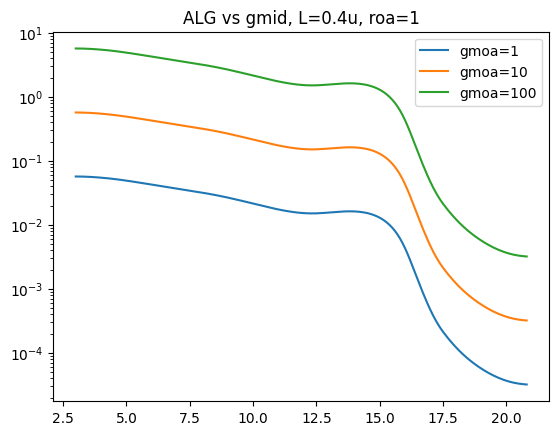

In [34]:
from sympy.utilities.lambdify import lambdify
lam_f = lambdify([gm1, gds, roa, gm, s], tf_openloop[1,3])


gm_test = [1, 10, 100]

for index, value in enumerate(gm_test):
    plt.plot(gmid_sweep, lam_f(m3gm[0], m3gds[0], 1, gm_test[index], 0))
plt.title("ALG vs gmid, L=0.4u, roa=1")
plt.yscale('log')
plt.legend(['gmoa=1','gmoa=10','gmoa=100'])

In [35]:
tf_openloop = TransferFunction(*tf_openloop[1,3].as_numer_denom(), s)
tf_openloop

TransferFunction(1000.0*gm*gm1*roa, 1.001e-9*gds*roa*s + 1000.0*gds + 1.001e-20*roa*s**2 + 1.001e-12*roa*s + 1.0e-8*s + 1.0, s)

In [36]:
"""
m3gm_0 = m3gm[0,:]
m3gds_0 = m3gds[0,:]

m3gm_0 = m3.numpy.logical_not(numpy.isnan(c))
"""

tf_openloop = [tf_openloop.subs({gm1: val1, gds: val2, roa: 10, gm: 100}) for val1, val2 in zip(m3gm[1,:], m3gds[1,:])]
tf_openloop

[TransferFunction(43.7828085625849, 1.001e-19*s**2 + 1.00101471712903e-8*s + 1.01370342560028, s),
 TransferFunction(43.6053433789321, 1.001e-19*s**2 + 1.00101352470212e-8*s + 1.01251218992689, s),
 TransferFunction(43.5081510450169, 1.001e-19*s**2 + 1.00101244627369e-8*s + 1.01143483885034, s),
 TransferFunction(43.4430734263882, 1.001e-19*s**2 + 1.00101146780344e-8*s + 1.0104573460915, s),
 TransferFunction(43.3387112531152, 1.001e-19*s**2 + 1.00101057679774e-8*s + 1.00956723051174, s),
 TransferFunction(43.1794582451272, 1.001e-19*s**2 + 1.00100977061981e-8*s + 1.00876185795675, s),
 TransferFunction(42.9657318901421, 1.001e-19*s**2 + 1.00100903868638e-8*s + 1.00803065572492, s),
 TransferFunction(42.7066658571324, 1.001e-19*s**2 + 1.00100836578407e-8*s + 1.00735842564794, s),
 TransferFunction(42.4065244126667, 1.001e-19*s**2 + 1.00100775007107e-8*s + 1.00674332774414, s),
 TransferFunction(42.0916757573929, 1.001e-19*s**2 + 1.00100719421242e-8*s + 1.00618802439456, s),
 TransferFu

In [37]:
def get_uf_pm(tf_openloop):
    openloop_bode_data = np.array(bode_magnitude_numerical_data(tf_openloop, initial_exp=0.1, final_exp=10))
    openloop_phase_data = np.array(bode_phase_numerical_data(tf_openloop, initial_exp=0.1, final_exp=10))

    index = np.absolute(openloop_bode_data[1]).argmin()
    uf = openloop_bode_data[0][index]
    pm = 180 + openloop_phase_data[1][index]*180/np.pi
    return uf, pm
    

In [38]:
pm = []
uf = []
for index, tf in enumerate(tf_openloop):
    a, b = get_uf_pm(tf)
    pm.append(b)
    uf.append(a)

NameError: name 'nan' is not defined

(80.0, 130.0)

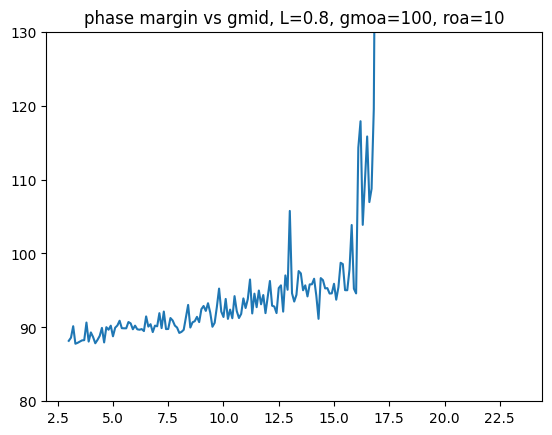

In [46]:
plt.plot(gmid_sweep[:205], pm)
plt.title('phase margin vs gmid, L=0.8, gmoa=100, roa=10')
plt.ylim([80, 130])

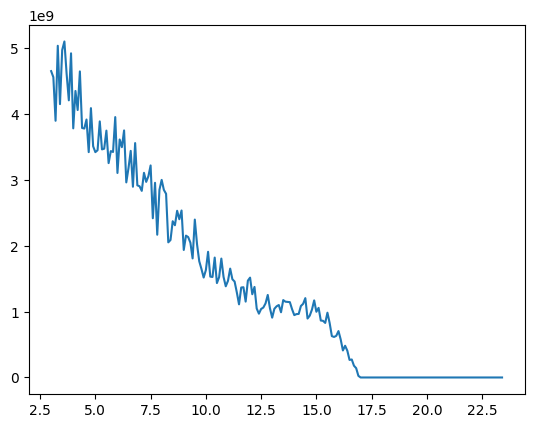

In [45]:
plt.plot(gmid_sweep[:205], uf)
plt.title('Unity frequency vs gmid, L=0.8, gmoa=1000, roa=1')

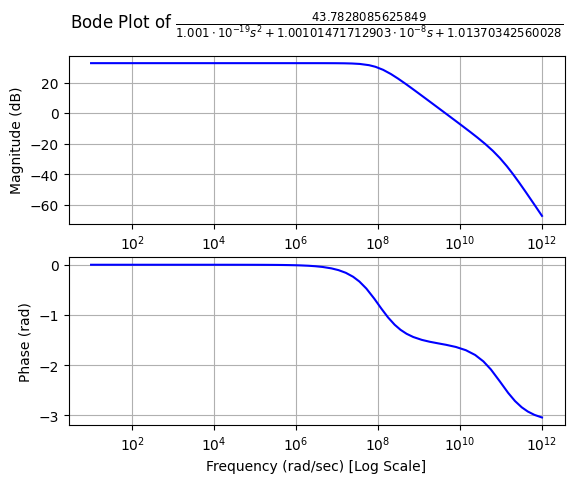

In [41]:
bode_plot(tf_openloop[0], initial_exp=1, final_exp=12)

# MNA with the full small-signal model

In [8]:
import ldo_mna as mna
## Matriz G del sistema (pasivos)
G = mna.get_G_matrix(M_1a, M_1b, M_2a, M_2b, M_4a, M_4b, R1, R2)
## Matriz B del sistema de ecuaciones (se apagan todas las fuentes dc y se deja solo la fuente AC de VDD - > para obtener PSRR)
B = sym.Matrix([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])    #(v1, v2, v3, v4, v5, v6, v8, Ibias, vdd, vref, v9)    

### PSRR_DC just with G matrix (DC)

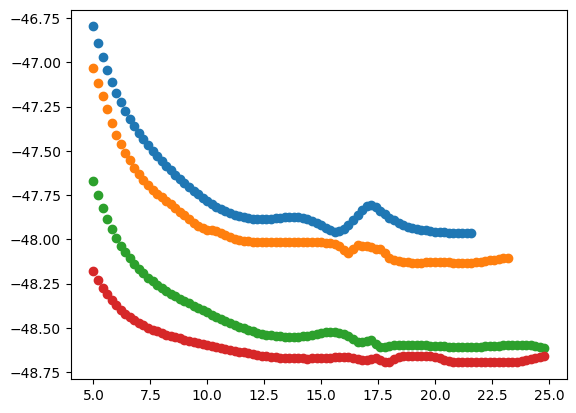

In [10]:
# 1. Lambdify the matrix so the parameters of the Pass Transistor can be replaced
gm_3 = sym.Symbol('gm_3')
gds_3 = sym.Symbol('gds_3')
PSRR_DC_lamb = sym.lambdify([gm_3, gds_3],(G.inv()*B)[9])
#print(PSRR_DC_lamb(np.multiply(M_3.gm, M_3.W*1e6), np.multiply(M_3.gds, M_3.W*1e6)))

# 2. Evaluation of the parameters into the transfer functioon matrix
## (IMPORTANt) The gm and gds must be scaled respect the W of the LUTs transistors. In other words, gm and gds must be mul by the PT W.
PSRR_DC = 20*np.log10((-1*PSRR_DC_lamb(np.multiply(M_3.gm, M_3.W*1e6), np.multiply(M_3.gds, M_3.W*1e6))))
for idx, value in enumerate(l3):
    plt.scatter(gmid_sweep, PSRR_DC[idx])

In [11]:
## PSRR just with equations, not with the euqation system.
20*np.log10(1/(M_1a.gm/(M_2a.gds+M_1a.gds)*np.multiply(M_3.gm, M_3.W*1e6)/(np.multiply(M_3.gds, M_3.W*1e6)+1/1800)*R2/(R1+R2)))[0][0]

-43.646571732790775

PSRR_DC: Best Fit and Multiobjective Optimization without considering conditions

In [3]:
## Second function to optimize, considering the PSRR as the first one.
L = sym.Symbol('L')
W = sym.Symbol('W')
Area = sym.lambdify([L, W], L+W)   # Total area of the pass transistor

l3_reshaped = np.transpose(np.tile(l3, (100,1)))
f_2 = Area(l3_reshaped, M_3.W)

f_1 = PSRR_DC

plt.scatter(f_2,f_1)
plt.xscale('log')

NameError: name 'sym' is not defined

In [2]:
import paretoset as pareto
import pandas as pd

opt = pd.DataFrame({"area": np.ndarray.flatten(f_2), "PSRR_DC": np.ndarray.flatten(f_1)})
mask = pareto.paretoset(opt, sense=["min", "min"])

pareto_frontier = opt[mask]

plt.scatter(f_2,f_1)
plt.scatter(pareto_frontier["area"], pareto_frontier["PSRR_DC"])
plt.xscale('log')
plt.title('PSRR_DC')
plt.ylabel('PSRR')
plt.xlabel('Pass transistor Area')
plt.legend(['nominal', 'pareto frontier'])

NameError: name 'f_2' is not defined

## Phase Margin and bode plot

In [17]:
import cmath as math

## Bode plot
def get_bode(s_sweep, G_lamb, C, B, index, L, eq):
    
    
    cgs_3 = sym.Symbol('cgs_3')
    cgd_3 = sym.Symbol('cgd_3')
    s = sym.Symbol('s')
    C_lamb = sym.lambdify([cgs_3, cgd_3, s], C)
    
    bode_data = []
    phase_data = []
    G = G_lamb(np.multiply(M_3.gm[L, index], M_3.W[L, index]*1000000), np.multiply(M_3.gds[L, index], M_3.W[L, index]*1000000))

    for idx, value in enumerate(s_sweep):
        PSRR = (np.linalg.inv(G+C_lamb(np.abs(M_3.cgs[L, index]*312.78*10), np.abs(M_3.cgd[L, index]*312.78*10), value*1j))*B)[eq]
        magnitude = 20*np.log10(float(np.abs(PSRR)))
        bode_data.append(magnitude)
        phase_data.append(math.phase(PSRR))
        
    return bode_data, phase_data

## Get phase margin, could be improved.
def get_PM(s_sweep, G, C_lamb, B, index, L, eq, cgs, cgd):
    
    #bode_data = []
    #phase_data = []

    """
    s_sweep = np.logspace(0, 10, num=200, base=10)
    PSRR = [(np.linalg.inv(G+C_lamb(cgs, cgd, s*1j))*B)[6] for s in s_sweep]
    magnitude = 20*np.log10((np.abs(PSRR)).astype(float))

    print(magnitude)

    return 0
    """

    s = 0.1
    for i in range(50):
        PSRR = (np.linalg.inv(G+C_lamb(cgs, cgd, s*1j))*B)[eq]
        magnitude = 20*np.log10(float(np.abs(PSRR)))
        #print(magnitude)
        #print(s)
        if np.abs(magnitude)>5:
            next_s = s*(np.abs(magnitude)*0.3)
            #bode_data.append(magnitude)
            #phase_data.append(math.phase(PSRR))
        else:
            #print("END mag",magnitude)
            #print("END phase",(180/np.pi)*math.phase(PSRR))
            return (180/np.pi)*math.phase(PSRR)
        s = next_s
        
    return 0

### Closed loop bode and phase margin just for demostration

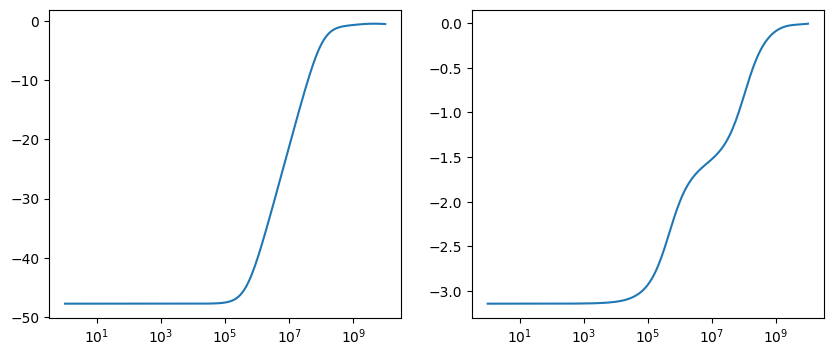

In [18]:
s_sweep = np.logspace(0, 10, num=200, base=10)
C = mna.get_C_matrix(M_1a, M_1b, M_2a, M_2b, M_4a, M_4b, R1, R2)
B = sym.Matrix([0, 0, 0, 0, 0, 0, 0, 1, 0, 0]) 

G = mna.get_G_matrix(M_1a, M_1b, M_2a, M_2b, M_4a, M_4b, R1, R2)
gm_3 = sym.Symbol('gm_3')
gds_3 = sym.Symbol('gds_3')
G_lamb = sym.lambdify([gm_3, gds_3], G)

bode, phase = get_bode(s_sweep, G_lamb, C, B, 25, 0, 9)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(s_sweep, bode)
ax1.set_xscale('log')

ax2.plot(s_sweep, phase)
ax2.set_xscale('log')

In [49]:
PM =  get_PM(s_sweep, G, C, B, 25, 0)
print(PM)

-47.78343230239236
0.1
-47.78343230178076
47.78343230239236
-47.7833521783147
22832.564025680895
-40.61286489875977
10910164.479730291
0.2359541320411053
4430930360.38534
END mag 0.2359541320411053
END phase 7.558053811497156
([-47.78343230239236, -47.78343230178076, -47.7833521783147, -40.61286489875977], [], 4430930360.38534)


### OpenLoop Gain and Phase margin

In [21]:
G = mna.get_openloop_G_matrix(M_1a, M_1b, M_2a, M_2b, M_4a, M_4b, R1, R2)
G = G.subs({gm_3: M_3.gm[0,25]*312, gds_3: M_3.gds[0,25]*312})
B = sym.Matrix([0, 0, 0, 0, 0, 0, 0, 1])
print(G.inv()*B)
print(20*np.log10(float((G.inv()*B)[6])))

Matrix([[0.483561750979054], [-46.1110716523671], [0.253079187825016], [1], [0], [3290.15860310879], [2193.43906873919], [0]])
66.82251149396325


In [24]:
C = mna.get_openloop_C_matrix(M_1a, M_1b, M_2a, M_2b, M_4a, M_4b, R1, R2, cl)
cgs_3 = sym.Symbol('cgs_3')
cgd_3 = sym.Symbol('cgd_3')
s = sym.Symbol('s')
C = C.subs({cgs_3: M_3.cgs[0,25]*312, cgd_3: M_3.cgd[0,25]*312, s: 1e9})
A = (G+C)
A

Matrix([
[1.1867457e-5,             -9.87e-10, -1.350152e-5,            0,           0,                    0,       0,  0],
[ 7.436813e-6, -0.000589737988311538,   -1.5339e-5, 1.5169749e-5,           0, -4.87417256792674e-7,       0,  0],
[  -1.1652e-7,              -1.69e-7,  3.277524e-5,    -1.687e-5, 1.582728e-5,                    0,       0,  0],
[           0,             -2.51e-10,      -1.7e-6,  1.700251e-6,           0,                    0,       0, -1],
[           0,                     0,     -2.72e-9,            0, 2.092972e-5,                    0,       0,  0],
[           0,   0.00693248988512995,            0,            0,           0,   0.0051043187047574, -1.0e-5,  0],
[           0,                     0,            0,            0,           0,              -1.0e-5,  1.5e-5,  0],
[           0,                     0,            0,            1,           0,                    0,       0,  0]])

In [25]:
A.inv()*B

Matrix([
[  0.588049585151347],
[ 0.0197166323381751],
[  0.516877633432038],
[                  1],
[6.71727649932796e-5],
[-0.0268133943297588],
[-0.0178755962198392],
[8.21554074290819e-7]])

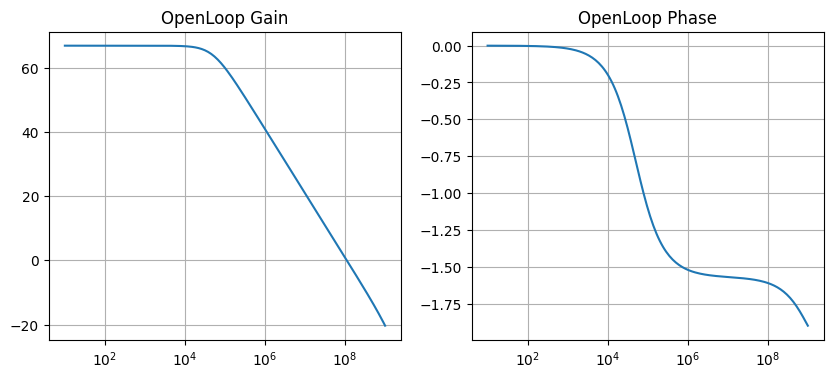

In [56]:
s_sweep = np.logspace(1, 9, num=200, base=10)
C = mna.get_openloop_C_matrix(M_1a, M_1b, M_2a, M_2b, M_4a, M_4b, R1, R2, 1e-15)
G = mna.get_openloop_G_matrix(M_1a, M_1b, M_2a, M_2b, M_4a, M_4b, R1, R2)
gm_3 = sym.Symbol('gm_3')
gds_3 = sym.Symbol('gds_3')
G_lamb = sym.lambdify([gm_3, gds_3], G)
B = sym.Matrix([0, 0, 0, 0, 0, 0, 0, 1])

bode, phase = get_bode(s_sweep, G_lamb, C, B, 25, 0, 6)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(s_sweep, bode)
ax1.set_xscale('log')
ax1.set_title('OpenLoop Gain')
ax1.grid()

ax2.plot(s_sweep, phase)
ax2.set_title('OpenLoop Phase')
ax2.set_xscale('log')
ax2.grid()


In [27]:
xschem_mag = [] 
xschem_phase = [] 
xschem_mag_x = []
xschem_phase_x = []

aux = 3
f = open('stability_analysis.txt','r') 
for row in f: 
    row = row.split(' ')
    if(row[3]==""):
        aux=2
    xschem_mag.append(float(row[aux]))
    xschem_mag_x.append(float(row[1]))
    xschem_phase.append(float(row[aux+3])) 
    xschem_phase_x.append(float(row[aux+2]))

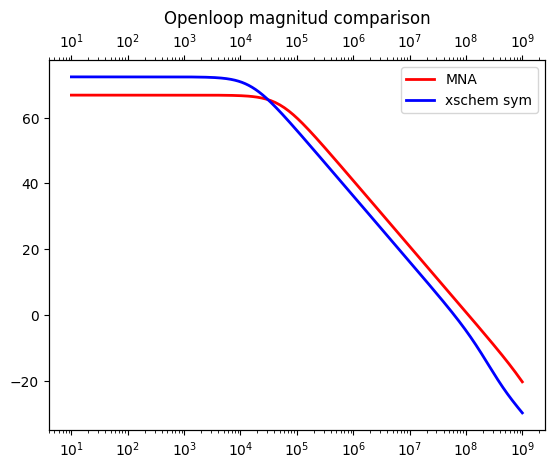

In [57]:
f, ax = plt.subplots(1,1)
ax2 = ax.twiny()

l1 = ax.plot(s_sweep, bode ,color='r', label='MNA',linewidth=2)
ax.set_xscale('log')
l2= ax2.plot(xschem_mag_x, xschem_mag,color='b', label='xschem sym',linewidth=2)
ax2.set_xscale('log')
ax2.set_title('Openloop magnitud comparison')
ax.legend( handles=l1+l2 )

In [1]:
f, ax = plt.subplots(1,1)
ax2 = ax.twiny()
phase = np.asarray(phase)
ax.plot(s_sweep, np.divide(phase*180, np.pi),color='r', label='MNA',linewidth=2)
ax.set_xscale('log')
ax2.plot(xschem_phase_x, (xschem_phase),color='b', label='xschem sym',linewidth=1)
ax2.set_xscale('log')
ax2.set_title('Openloop phase comparison')
ax.legend( handles=l1+l2 )

NameError: name 'plt' is not defined

In [38]:
C = mna.get_openloop_C_matrix(M_1a, M_1b, M_2a, M_2b, M_4a, M_4b, R1, R2, 1e-15)
G = mna.get_openloop_G_matrix(M_1a, M_1b, M_2a, M_2b, M_4a, M_4b, R1, R2)

cgs_3 = sym.Symbol('cgs_3')
cgd_3 = sym.Symbol('cgd_3')
s = sym.Symbol('s')
C_lamb = sym.lambdify([cgs_3, cgd_3, s], C)

gm_3 = sym.Symbol('gm_3')
gds_3 = sym.Symbol('gds_3')
G_lamb = sym.lambdify([gm_3, gds_3], G)

pm = []
for idx, value in enumerate(np.ndarray.flatten(M_3.W)):
    cgs = np.ndarray.flatten(M_3.cgs)[idx]*value*1000*10
    cgd = np.ndarray.flatten(M_3.cgs)[idx]*value*1000*10
    gm = np.ndarray.flatten(M_3.gm)[idx]*value*1000
    gds = np.ndarray.flatten(M_3.gds)[idx]*value*1000

    if(np.isnan(value) or np.isnan(cgs) or np.isnan(cgd) or np.isnan(gm) or np.isnan(gds)):
        print("INVALID")
        pm.append(0)
    else:
        G = G_lamb(gm, gds)
        pm.append(get_PM(s_sweep, G, C_lamb, B, idx, 0, 6, cgs, cgd))
    print(pm[-1])

96.23285331084645
98.76621507564653
101.13634429631546
103.30268982533227
105.24026731223715
106.93813688392434
108.40733704569459
109.69548881925449
110.8011920755875
111.72326662211229
112.46513596409119
113.03274617729224
113.43294608212474
113.67227810757502
113.7561162360754
113.68810642081037
113.46989630335244
105.92633631014141
107.45665925912414
109.04104324273185
110.66834519603754
112.31177071193001
113.94208752825564
115.5294172563749
117.04513450848661
118.46360542136122
119.76358406645998
120.92920006444967
121.9505428784359
122.82385235705812
123.55129222806696
124.1402652963108
124.60225731682266
124.95126464510814
125.20193417764104
125.36758246259264
125.45824199487254
125.47864357999445
125.43427411259796
125.34116498049322
125.21643322834021
125.08060805692324
124.95909741796349
124.8813083106735
124.87758864557092
124.97405056272322
125.18502364040346
125.5025452401784
125.89350992309336
126.27553906502777
126.46923972562801
126.15324791625189
124.83063078798646
11

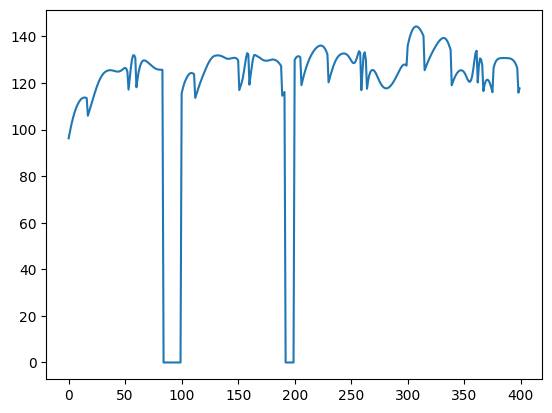

In [156]:
plt.plot(pm)

### Load Regulation

In [72]:
import ldo_mna as mna
## Matriz G del sistema (pasivos)
G = mna.get_G_matrix(M_1a, M_1b, M_2a, M_2b, M_4a, M_4b, R1, R2)
## Matriz B del sistema de ecuaciones (se apagan todas las fuentes dc y se deja solo la fuente AC de VDD - > para obtener PSRR)
B = sym.Matrix([0, 0, 0, 0, 0, 0, 1.5e-6, 1.8, 0.8, -0.667e-3])    #(v1, v2, v3, v4, v5, v6, v8, Ibias, vdd, vref, v9)

# 1. Lambdify the matrix so the parameters of the Pass Transistor can be replaced
gm_3 = sym.Symbol('gm_3')
gds_3 = sym.Symbol('gds_3')
PSRR_DC_lamb = sym.lambdify([gm_3, gds_3],(G.inv()*B)[9])

load_nom = PSRR_DC_lamb(np.multiply(M_3.gm, M_3.W*1e6), np.multiply(M_3.gds, M_3.W*1e6))

In [73]:
## Matriz B del sistema de ecuaciones (se apagan todas las fuentes dc y se deja solo la fuente AC de VDD - > para obtener PSRR)
B = sym.Matrix([0, 0, 0, 0, 0, 0, 1.5e-6, 1.8, 0.8, -0.667e-2])    #(v1, v2, v3, v4, v5, v6, v8, Ibias, vdd, vref, v9)

# 1. Lambdify the matrix so the parameters of the Pass Transistor can be replaced
gm_3 = sym.Symbol('gm_3')
gds_3 = sym.Symbol('gds_3')
PSRR_DC_lamb = sym.lambdify([gm_3, gds_3],(G.inv()*B)[9])

load_c1 = PSRR_DC_lamb(np.multiply(M_3.gm, M_3.W*1e6), np.multiply(M_3.gds, M_3.W*1e6))

Text(0.5, 1.0, 'Load regulation')

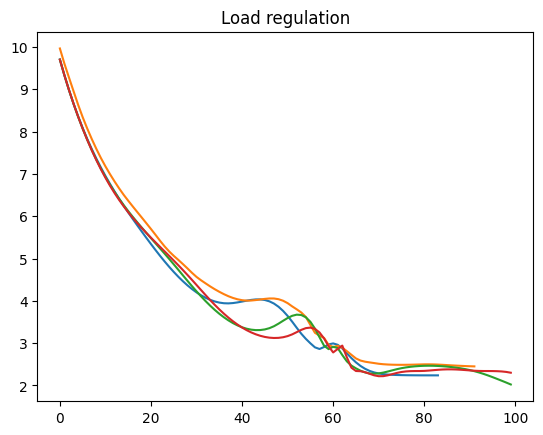

In [74]:
load_regulation = (load_nom-load_c1)/(0.667e-3-0.667e-2)
for idx, value in enumerate(l3):
    plt.plot(load_regulation[idx])
plt.title('Load regulation')

In [39]:
pm_mask = []
pm_condition = 125
for idx, value in enumerate(pm):
    if value > pm_condition:
        pm_mask.append(True)
    else:
        pm_mask.append(False)

Text(0, 0.5, 'Phase Margin')

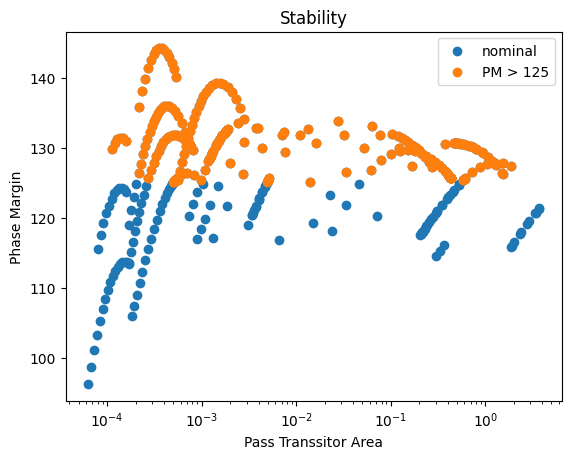

In [70]:
pm = np.array(pm)
indices = np.arange(0, 400, 1)
plt.scatter(opt["area"], pm)
plt.scatter(opt[pm_mask]["area"], pm[pm_mask])
plt.xscale('log')
plt.legend(['nominal', 'PM > 125'])
plt.title("Stability")
plt.xlabel("Pass Transsitor Area")
plt.ylabel("Phase Margin")

In [180]:
pm.size
indices.size

1

## Pareto with PM condition

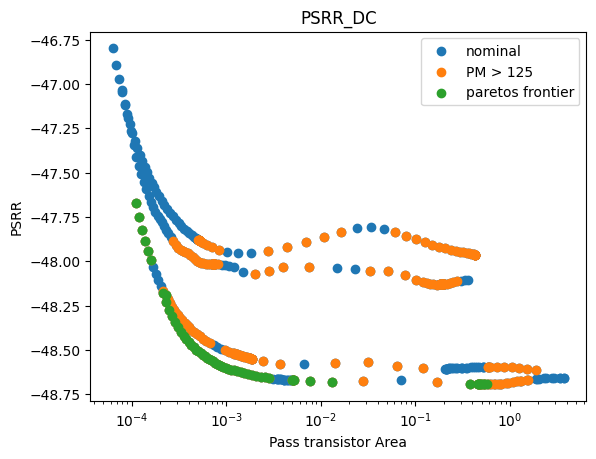

In [54]:
import paretoset as pareto
import pandas as pd

opt = pd.DataFrame({"area": np.ndarray.flatten(f_2), "PSRR_DC": np.ndarray.flatten(f_1)})
opt_filtered = opt[pm_mask]

mask = pareto.paretoset(opt_filtered, sense=["min", "min"])
pareto_frontier = opt_filtered[mask]

plt.scatter(f_2,f_1)
plt.scatter(opt_filtered["area"], opt_filtered["PSRR_DC"])
plt.scatter(pareto_frontier["area"], pareto_frontier["PSRR_DC"])
plt.xscale('log')
plt.title('PSRR_DC')
plt.ylabel('PSRR')
plt.xlabel('Pass transistor Area')
plt.legend(['nominal', 'PM > 125', 'paretos frontier'])

In [42]:
plt.scatter(opt["Area"], f_1[pm_mask])
plt.xscale('log')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4 but corresponding boolean dimension is 400

In [43]:
f_2

array([[6.34047852e-05, 6.82652757e-05, 7.33477187e-05, 7.86468734e-05,
        8.41596878e-05, 8.98867697e-05, 9.58336877e-05, 1.02007066e-04,
        1.08415019e-04, 1.15071926e-04, 1.22000178e-04, 1.29231986e-04,
        1.36811418e-04, 1.44796741e-04, 1.53263173e-04, 1.62306221e-04,
        1.72045812e-04, 1.82631498e-04, 1.94251327e-04, 2.07096619e-04,
        2.21256539e-04, 2.36795844e-04, 2.53760848e-04, 2.72169824e-04,
        2.92001385e-04, 3.13181064e-04, 3.35566689e-04, 3.58933656e-04,
        3.82961743e-04, 4.07225655e-04, 4.31191768e-04, 4.54223526e-04,
        4.75597379e-04, 4.94530078e-04, 5.10216763e-04, 5.21877822e-04,
        5.28811392e-04, 5.30433731e-04, 5.26935658e-04, 5.19936030e-04,
        5.11191378e-04, 5.02365098e-04, 4.94990304e-04, 4.90495235e-04,
        4.90284390e-04, 4.95873790e-04, 5.09090292e-04, 5.32362852e-04,
        5.69187786e-04, 6.24922456e-04, 7.08163657e-04, 8.33355949e-04,
        1.02593075e-03, 1.33294553e-03, 1.84619331e-03, 2.754132